In [385]:
import intel_extension_for_pytorch as ipex
from torchvision.datasets import CIFAR10
from torchvision import transforms
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
from torch import optim
import torch.nn as nn
import torch
from tqdm import tqdm
from typing import Tuple
import imageio
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Dataset

In [386]:
BATCH_SIZE = 64

trainset = CIFAR10(root='../data', train=True,  transform=transforms.ToTensor(), download=True)
testset  = CIFAR10(root='../data', train=False, transform=transforms.ToTensor(), download=True)

trainloader = DataLoader(trainset, BATCH_SIZE, shuffle=True, num_workers=8)
testloader  = DataLoader(testset, BATCH_SIZE, shuffle=True, num_workers=8)

classes = {i:name for i, name in enumerate(trainset.classes)}
classes

Files already downloaded and verified
Files already downloaded and verified


{0: 'airplane',
 1: 'automobile',
 2: 'bird',
 3: 'cat',
 4: 'deer',
 5: 'dog',
 6: 'frog',
 7: 'horse',
 8: 'ship',
 9: 'truck'}

In [387]:
def show_imgs(imgs: torch.Tensor, labels: torch.Tensor):
    imgs = imgs.cpu().detach().clone().permute(0, 2, 3, 1)
    labels = labels.cpu().detach().clone()
    n = len(labels)
    rows, cols = n // 4, 4
    plt.figure(figsize=(8, 4))
    for i in range(n):
        plt.subplot(rows, cols, i+1)
        plt.imshow(imgs[i-1])
        plt.title(classes[labels[i-1].item()])
        plt.axis(False)
    plt.show()

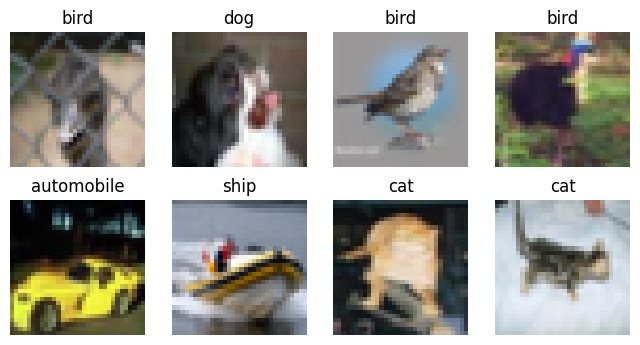

In [388]:
imgs, labels = next(iter(trainloader))
show_imgs(imgs[:8], labels[:8])

### Model

In [394]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, n_classes: int ):
        super(Generator, self).__init__()
        self.latent_dim = latent_dim
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=latent_dim)
        
        self.model = nn.Sequential(
            nn.Unflatten(dim=-1, unflattened_size=(latent_dim, 1, 1)),
            # ConvBlock2 (4x4)
            nn.UpsamplingBilinear2d(size=(4,4)),
            nn.Conv2d(in_channels=latent_dim,
                      out_channels=256,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),            
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock3 (8x8)
            nn.UpsamplingBilinear2d(size=(8,8)),
            nn.Conv2d(in_channels=256,
                      out_channels=128,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # ConvBlock4 (16x16)
            nn.UpsamplingBilinear2d(size=(16,16)),
            nn.Conv2d(in_channels=128,
                      out_channels=64,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),
            nn.BatchNorm2d(num_features=64, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            # Final Conv Transpose (32x32)
            nn.UpsamplingBilinear2d(size=(32,32)),
            nn.Conv2d(in_channels=64,
                      out_channels=3,
                      kernel_size=3,
                      stride=1, padding='same',
                      bias=False),
            nn.Sigmoid())
    
    def forward(self, labels):
        cls_embds = self.embeddings(labels)
        eps = torch.randn_like(cls_embds)
        return self.model(cls_embds + eps)

In [395]:
class Discriminator(nn.Module):
    def __init__(self, n_classes: int, img_shape: Tuple):
        super(Discriminator, self).__init__()
        self.n_classes = n_classes
        self.embeddings = nn.Embedding(num_embeddings=n_classes,
                                       embedding_dim=torch.prod(img_shape))
        self.model = nn.Sequential(
            nn.Conv2d(in_channels=6,
                      out_channels=64,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=64, 
                      out_channels=128,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=128, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=128, 
                      out_channels=256,
                      kernel_size=3,
                      stride=2, padding=1),
            nn.BatchNorm2d(num_features=256, momentum=0.9),
            nn.LeakyReLU(negative_slope=0.15),
            nn.Dropout2d(p=0.1),
            
            nn.Conv2d(in_channels=256, 
                      out_channels=1,
                      kernel_size=4,
                      stride=1, padding=0), 
            nn.Flatten())
        
    def forward(self, imgs, labels):
        embds = self.embeddings(labels).view(imgs.shape)
        concat = torch.cat((imgs, embds), dim=1)
        return self.model(concat)

In [396]:
class CGAN(nn.Module):
    def __init__(self, generator, discriminator, LAMBDA_GP: float=10):
        super(CGAN, self).__init__()
        self.generator = generator
        self.discriminator = discriminator
        self.LAMBDA_GP = LAMBDA_GP

    def forward(self, labels):
        with torch.inference_mode():
            out = self.generator(labels)      
        return out.detach()
    
    def compile(self, g_optimizer, d_optimizer):
        self.g_optimizer = g_optimizer
        self.d_optimizer = d_optimizer
    
    def gradient_penalty(self, real_imgs, fake_imgs, labels):
        alpha = torch.randn((*real_imgs.shape[:2], 1, 1)).to(real_imgs.device)
        diff = fake_imgs - real_imgs
        interpolation = real_imgs + alpha * diff
        preds = self.discriminator(interpolation, labels)
        grad_outputs = torch.ones_like(preds)
        gradients = torch.autograd.grad(
            outputs=preds,
            inputs=interpolation,
            grad_outputs=grad_outputs,
            create_graph=True,
            retain_graph=True)[0]
        
        gradients = gradients.view(labels.shape[0], -1)
        grad_norm = gradients.norm(2, 1)
        return ((grad_norm-1)**2).mean()

### Model Initialization

In [407]:
EPOCHS = 300
LATENT_DIM = 100
DG_TRAIN_RATIO = 5
LAMBDA_GP = 10

device = 'xpu' if ipex.xpu.is_available() else 'cpu'

generator = Generator(LATENT_DIM, len(classes))
discriminator = Discriminator(len(classes), torch.tensor(imgs[0].shape))

g_optimizer = optim.Adam(generator.parameters())
d_optimizer = optim.Adam(discriminator.parameters())

cgan = CGAN(generator, discriminator, LAMBDA_GP)
cgan.compile(g_optimizer, d_optimizer)

### Training Implementation Scheme

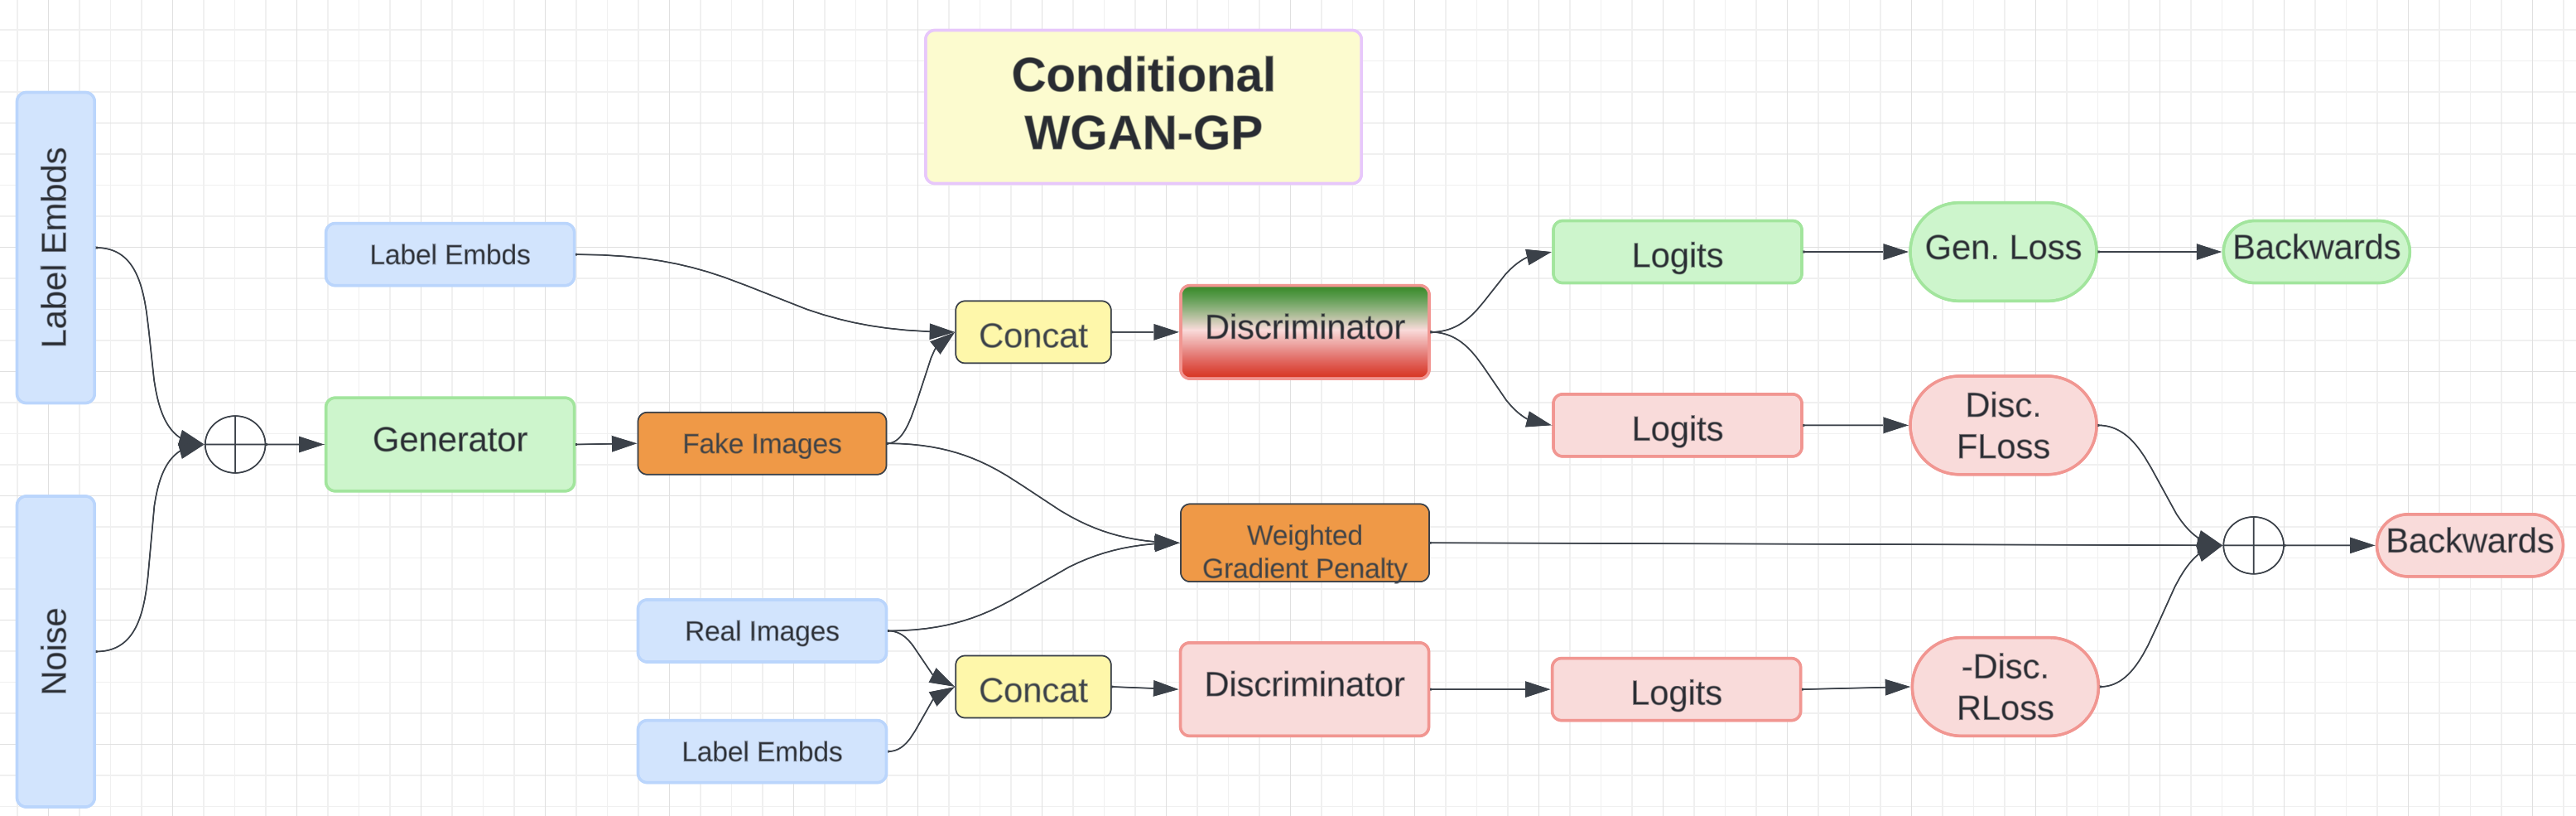

In [397]:
def train_step(model: nn.Module, trainloader: DataLoader, 
               device: torch.device, DG_TRAIN_RATIO:int=3):
    
    mean_g_loss, mean_d_loss = .0, .0
    for i, (real_imgs, labels) in enumerate(tqdm(trainloader)):
        real_imgs = real_imgs.to(device)
        labels = labels.to(device)
        
        # *******************
        # Train Discriminator
        # *******************
        
        # setting grads to 0 after last generator backprop
        model.d_optimizer.zero_grad()
        
        # generated images conditioned on labels
        fake_imgs = model.generator(labels)
        
        # discriminator output based on fake&real images
        d_fake = model.discriminator(fake_imgs.detach(), labels)
        d_real = model.discriminator(real_imgs, labels)
        d_gp = model.gradient_penalty(
            real_imgs,fake_imgs.detach().clone().requires_grad_(True),labels)
        d_loss = d_fake.mean() - d_real.mean() + d_gp * model.LAMBDA_GP
        
        # discriminator backpropagation
        d_loss.backward()
        model.d_optimizer.step()

        mean_d_loss += d_loss.item()
        
        if i % DG_TRAIN_RATIO == 0:
            # ***************
            # Train Generator
            # ***************
            
            # generator backpropagation        
            model.g_optimizer.zero_grad()
            # print(fake_imgs.shape)
            d_fake = model.discriminator(fake_imgs, labels)
            g_loss = -torch.mean(d_fake)
            
            mean_g_loss += g_loss.item()

            g_loss.backward()
            model.g_optimizer.step()

    n_batches = len(trainloader)
    mean_g_loss /= n_batches
    mean_d_loss /= n_batches
    return [mean_g_loss, mean_d_loss]

In [398]:
def test_step(model: nn.Module, testloader: DataLoader,
              device: torch.device):
    
    mean_g_loss, mean_d_loss = .0, .0
    with torch.inference_mode():
        for real_imgs, labels in tqdm(testloader):
            real_imgs = real_imgs.to(device)
            labels = labels.to(device)

            fake_imgs = model.generator(labels)
            d_fake = model.discriminator(fake_imgs, labels)
            d_real = model.discriminator(real_imgs, labels)
            d_loss = d_fake.mean() - d_real.mean()
            g_loss = -torch.mean(d_fake)
            
            mean_g_loss += g_loss.item()
            mean_d_loss += d_loss.item()
            
        n_batches = len(testloader)
        mean_g_loss /= n_batches
        mean_d_loss /= n_batches
        
    return [mean_g_loss, mean_d_loss]

In [404]:
def train(model: nn.Module, trainloader: DataLoader,
          testloader: DataLoader, device: torch.device, 
          EPOCHS: int, DG_TRAIN_RATIO: int=3):
    model = model.to(device)
    results = [[] for _ in range(4)]
    
    gif_rand_labels = torch.randint(0, 10, (64,)).to(device)
    gif_gen_imgs = []
    
    for epoch in range(1, EPOCHS+1):
        print(f"Epoch ----------> {epoch}/{EPOCHS} | Training")
        train_results = train_step(model, trainloader, device, DG_TRAIN_RATIO)
        print(f"Generator Loss: {train_results[0]:.4f}")
        print(f"Discriminator Loss: {train_results[1]:.4f}")
        
        print("Testing")
        test_results = test_step(model, testloader, device)
        print(f"Generator Loss: {test_results[0]:.4f}")
        print(f"Discriminator Loss: {test_results[1]:.4f}")
        
        # saving results
        for i, l in enumerate(train_results + test_results): results[i].append(l)
        
        # gif frame generation
        gen_imgs = make_grid(model(gif_rand_labels).to(device='cpu')).permute(1, 2, 0).numpy()
        gen_imgs = (gen_imgs * 255).astype(np.uint8)
        gif_gen_imgs.append(gen_imgs)
    
        # save the training GIF after all frames have been collected
        imageio.mimsave(f'../gifs/cifar10_cwgan_gp_{epoch}_epochs.gif', gif_gen_imgs)
        imageio.mimsave(f'../gifs/cifar10_cwgan_gp_{epoch}_epochs_with_duration.gif', gif_gen_imgs, duration=EPOCHS//10)
        
        
        if epoch % 20 == 0:
            rand_labels = torch.randint(0, 10, (8,)).to(device)
            gen_imgs = model(rand_labels).to('cpu')
            show_imgs(gen_imgs, rand_labels.to('cpu'))
    
    return {'train_losses_g': results[0],
            'train_losses_d': results[1],
            'test_losses_g': results[2], 
            'test_losses_d': results[3]}

In [ ]:
results = train(cgan, trainloader, testloader, device, EPOCHS, DG_TRAIN_RATIO)

### Visualization

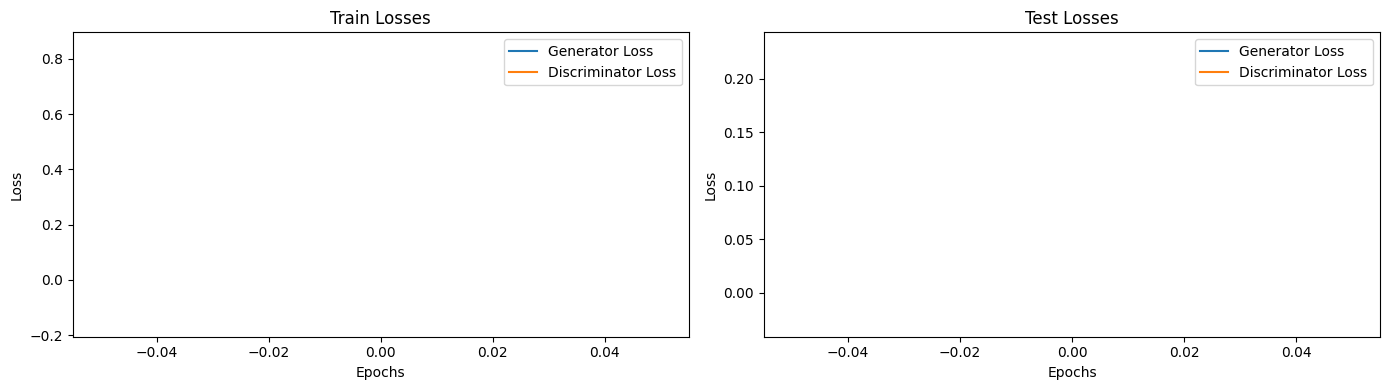

In [401]:
def plot_losses(ax, title, g_losses, d_losses):
    ax.plot(g_losses, label='Generator Loss')
    ax.plot(d_losses, label='Discriminator Loss')
    ax.title(title)
    ax.xlabel('Epochs')
    ax.ylabel('Loss')
    ax.legend()

plt.figure(figsize=(14, 4))
plt.subplot(121)
plot_losses(plt, "Train Losses", results['train_losses_g'], results['train_losses_d'])

plt.subplot(122)
plot_losses(plt, "Test Losses", results['test_losses_g'], results['test_losses_d'])
plt.tight_layout()
plt.show()

### Saving the Model

In [402]:
from pathlib import Path
MODEL_PATH = Path("../models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "cifar10_cwgan_gp.pth"
MODEL_SAVE_PATH = MODEL_PATH/MODEL_NAME
torch.save(cgan.state_dict(), MODEL_SAVE_PATH)

### Load The Model

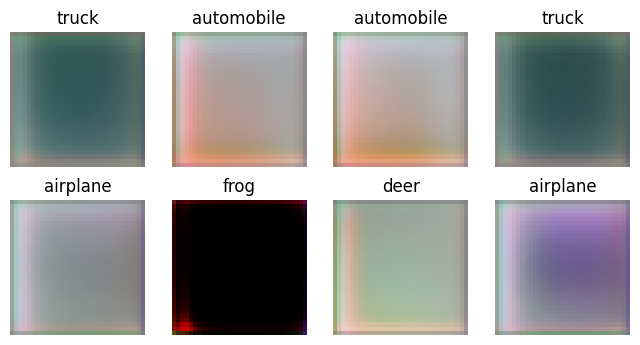

In [403]:
generator = Generator(LATENT_DIM, len(classes))
discriminator = Discriminator(len(classes), torch.tensor(imgs[0].shape))
cgan = CGAN(generator, discriminator)
cgan.load_state_dict(torch.load("../models/cifar10_cwgan_gp.pth"))
rand_labels = torch.randint(0, 10, (8,))
gen_imgs = cgan(rand_labels)
show_imgs(gen_imgs, rand_labels)